In [ ]:
import pandas as pd
import re,string
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np

!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import io
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Value Similarity

In [ ]:
pwc_df= pd.read_csv('PwC_Review.csv', encoding= "iso-8859-1")
pwc_df.head()

,ï»¿Title,Date Written,Rating,Current/Former,Job Title,Location,Recommendation?,Outlook,Main Text,Pros,Cons
0,Amazing place to grow and develop,"Sep 26, 2021",5.0,Former,Senior Management Consultant,NaN,Recommend,Business Outlook,Share,Focused a lot of early career development. Ama...,"Long hours, but honestly, not deal-breaking."
1,It's luck of the draw,"Sep 27, 2021",3.0,Current,International Tax Associate,NaN,Recommend,Business Outlook,Share,"The people, you will gain a ton of experience ...",Although the hours are flexible they are still...
2,Lots of politics,"Sep 28, 2021",4.0,Former,SAP Consultant,NaN,Recommend,Business Outlook,Share,Opportunity to work with lots of bright talent...,Very negative experience with a manager with z...
3,Its a massive ship,"Sep 30, 2021",3.0,Former,International Tax Associate,NaN,Recommend,Business Outlook,Share,"They are trying to change culture, and you can...",They are still a business and you are replacea...
4,PwC life,"Sep 21, 2021",4.0,Current,Risk and Regulatory Advisory Senior Associate,NaN,Recommend,Business Outlook,Share,Good pay and benefits Career opportunities are...,You work a lot. The firm preaches work life ba...


https://www.linkedin.com/pulse/brilliant-examples-company-values-amazon-google-microsoft-j-d-meier/

In [ ]:
### PwC Values and Behaviors:
pwc_values = """1) Act with integrity
Speak up for what is right, especially when it feels difficult
Expect and deliver the highest quality outcomes
Make decisions and act as if our personal reputations were at stake


2) Make a difference
Stay informed and ask questions about the future of the world we live in 
Create impact with our colleagues, our clients and society through our actions
Respond with agility to the ever changing environment in which we operate

3) Working at Google is fun
We expect our people to know and enjoy each other
We have a challenging/energetic work environment
We celebrate our successes and each other’s accomplishments – both professional and personal

4) Care
Make the effort to understand every individual and what matters to them
Recognise the value that each person contributes
Support others to grow and work in the ways that bring out their best

5) Work together
Collaborate and share relationships, ideas and knowledge beyond boundaries
Seek and integrate a diverse range of perspectives, people andideas
Give and ask for feedback to improve ourselves andothers

6) Reimagine the possible
Dare to challenge the status quo and try newthings
Innovate, test and learn from failure
Have an open mind to the possibilities in every idea"""

### What is Stemming?
* The idea of stemming is a sort of normalizing method. Many variations of words carry the same meaning, other than when tense is involved.
* Imagine every word in the English language, every possible tense and affix you can put on a word. Having individual dictionary entries per version would be highly redundant and inefficient.
* e.g. 
["python", "pythoner", "pythoning", "pythoned", "pythonly"] -> Stemming -> [python, python, python, python, pythonli]

In [ ]:
# Cosine Similarity
stemmer = nltk.stem.porter.PorterStemmer()
# In Python3, string.punctuation is a pre-initialized string used as string constant. \
# In Python, string.punctuation will give the all sets of punctuation.
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

    vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    # TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF features. 
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

def cosine_pros_cons(df, value_list):
    df.columns = ['title', 'date_written', 'rating', 'current_former', 'job_title',
       'location', 'recommendation', 'outlook', 'main_text', 'pros', 'cons'] # removed "advise_to_management" bc our df doesn't have the column.
    df.pros = df.pros.astype(str)
    df.cons = df.cons.astype(str)

    pros = df.pros.sum()
    cons = df.cons.sum()

    for value in value_list:
        print(value)
        print("Similarity with pros:",cosine_sim(pros,value))
        print("Similarity with cons:",cosine_sim(cons,value))
        print()

In [ ]:
cosine_pros_cons(pwc_df,pwc_values.split('\n\n'))

1) Act with integrity
Speak up for what is right, especially when it feels difficult
Expect and deliver the highest quality outcomes
Make decisions and act as if our personal reputations were at stake
Similarity with pros: 0.019152306148218664
Similarity with cons: 0.0427519372716153


2) Make a difference
Stay informed and ask questions about the future of the world we live in 
Create impact with our colleagues, our clients and society through our actions
Respond with agility to the ever changing environment in which we operate
Similarity with pros: 0.05529651281584707
Similarity with cons: 0.036435171079318804

3) Working at Google is fun
We expect our people to know and enjoy each other
We have a challenging/energetic work environment
We celebrate our successes and each other’s accomplishments – both professional and personal
Similarity with pros: 0.23325062545409045
Similarity with cons: 0.20169606685296104

4) Care
Make the effort to understand every individual and what matters to

# Sentiment

In [ ]:
fig_size = plt.rcParams["figure.figsize"]

#Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

### VADER
VADER is a lexicon and rule-based feeling analysis instrument that is explicitly sensitive to suppositions communicated in web-based media. VADER utilizes a mix of lexical highlights (e.g., words) that are, for the most part, marked by their semantic direction as one or the other positive or negative. Thus, VADER not only tells about the Polarity score yet, in addition, it tells us concerning how positive or negative a conclusion is.

* The VADER library returns 4 values such as:
  * pos: The probability of the sentiment to be positive
  * neu: The probability of the sentiment to be neutral
  * neg: The probability of the sentiment to be negative
  * compound: The normalized compound score which calculates the sum of all 
  
* lexicon ratings and takes values from -1 to 1
* Notice that the pos, neu and neg probabilities add up to 1. Also, the compound score is a very useful metric in case we want a single measure of sentiment. Typical threshold values are the following:

  * positive: compound score>=0.05
  * neutral: compound score between -0.05 and 0.05
  * negative: compound score<=-0.05

In [ ]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
import copy
analyser = SentimentIntensityAnalyzer()

def get_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence) # outputs sentiment scores (e.g. {'neg': 0.0, 'neu': 0.432, 'pos': 0.568, 'compound': 0.8476})
    return(snt['compound']) #return only compound score

def get_pos_neg(sentence):
    snt = analyser.polarity_scores(sentence)
    if(snt['pos'] > snt['neg']):
        return('pos')
    return('neg')

def sentiment_analysis(dfx):
    df = copy.deepcopy(dfx)
    df.columns = ['title', 'date_written', 'rating', 'current_former', 'job_title',
       'location', 'recommendation', 'outlook', 'main_text', 'pros', 'cons'] # removed "advice_to_management" bc our df doesn't have that column

    df.pros = df.pros.astype(str)
    df.cons = df.cons.astype(str)
    
    df['pc'] = df.pros + ' ' + df.cons
    
    df['sent_score'] = df.pc.map(get_sentiment_scores) #sentiment score == compound score
    df['pos_neg'] = df.pc.map(get_pos_neg) # get whether it is +ve or -ve 
    
    df['date'] = pd.to_datetime(df['date_written'], errors = 'coerce')
    df.set_index('date', inplace=True)
    df2 = df[['sent_score']].resample("M").mean() # resample the datetime data in minute bins
    y_mean = np.repeat(df['sent_score'].mean(), df2.shape[0]) # repeat mean of sentiment score by number of df2 rows
    # Plot the data
    plot(df2.index, y_mean, label='Mean', linestyle='--', color = 'k')
    plot(df2.index, df2['sent_score'], label="Sentiment Score") 
    plt.xlabel("Dates")
    plt.ylabel("Sentiment Score Mean")
    legend()
    # option_context: context manager is used to set the option in with statement temporarily.
    # Option values are restored automatically when you exit the with block
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): # temporarily set variables 'display.max_rows' and 'display.max_columns' as None
        print("Average sentiment score:",df['sent_score'].mean())
        print("--------------------------------------------------")
        print(df.groupby('current_former')[['sent_score']].mean())
        print("--------------------------------------------------")
        print(df.groupby('outlook')[['sent_score']].mean())
        print("--------------------------------------------------")
        print(df.groupby('recommendation')[['sent_score']].mean())
        print("--------------------------------------------------")
        print(df.job_title.value_counts()[:20])
        print("--------------------------------------------------")
        top_designations = df.job_title.value_counts().index[:20]
        print(df[df.job_title.isin(top_designations)].groupby('job_title')['sent_score'].mean().nlargest(20)) # .nlargest(): Returns the first n rows ordered by columns in descending order
        print("--------------------------------------------------")
        print("Top 10 Locations: {}".format(df['location'].value_counts()[:10]))
        top_locations = df.location.value_counts().index[:10]
        print(df[df.location.isin(top_locations)].groupby('location')['sent_score'].mean().nlargest(10))
        print(df[df.location.isin(top_locations) & df.job_title.isin(top_designations)].pivot_table(index='location', columns='job_title', values='sent_score',aggfunc='mean'))
        #print(df[df.location.isin(top_locations) & df.job_title.isin(top_designations) ].groupby(['location','job_title'])[['sent_score']].mean())

Average sentiment score: 0.5033832663316588
--------------------------------------------------
                sent_score
current_former            
Current           0.512983
Former            0.477542
--------------------------------------------------
                  sent_score
outlook                     
Business Outlook    0.503383
--------------------------------------------------
                sent_score
recommendation            
Recommend         0.503383
--------------------------------------------------
 Senior Associate               240
 Associate                      182
 Anonymous Employee             121
 Manager                        111
 Assurance Associate            101
 Director                        73
 Tax Associate                   66
 Senior Manager                  65
 Audit Associate                 38
 Consultant                      31
 Audit Senior Associate          28
 Experienced Associate           25
 Senior Consultant               23
 Experie

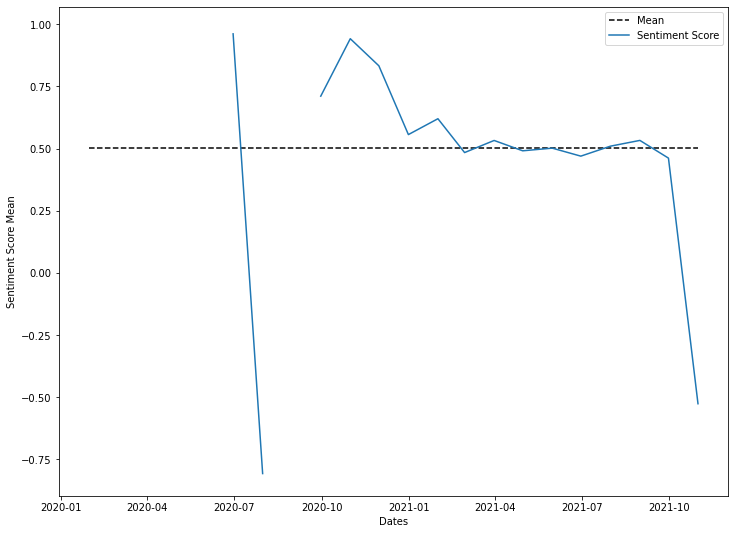

In [ ]:
sentiment_analysis(pwc_df)